# MonteCarloDropoutEnsemble
## Create and Evaluate a Monte Carlo Dropout Ensemble made of a separable convolutional classifier

## Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
# # Credit: https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
import data
from tensorflow import keras
import nets
from loaders import PremadeTripletClassifierSequence
import numpy as np
import matplotlib.pyplot as plt
import sys

/home/transposons/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Files

In [4]:
# file_name = '/home/zakaria/Data/IdentityData/ShortTrain/60.fa'#file_name = '../Data/sequences.fa'

data_dir = '../Data/Datasets/All/'


train_sequence = f'{data_dir}/train_sequences.fa'
valid_sequence = f'{data_dir}/valid_sequences.fa'
test_sequence = f'{data_dir}/test_sequences.fa'

reverse_train_sequence = f'{data_dir}/reverse_train_sequences.fa'
reverse_valid_sequence = f'{data_dir}/reverse_valid_sequences.fa'
reverse_test_sequence = f'{data_dir}/reverse_test_sequences.fa'

train_triplet_dis = f'{data_dir}/train_triplet_dis.npy'
valid_triplet_dis = f'{data_dir}/valid_triplet_dis.npy'
test_triplet_dis = f'{data_dir}/test_triplet_dis.npy'

train_triplet_sim = f'{data_dir}/train_triplet_sim.npy'
valid_triplet_sim = f'{data_dir}/valid_triplet_sim.npy'
test_triplet_sim = f'{data_dir}/test_triplet_sim.npy'

## Parameters

In [5]:
codings_size = 250 # Size of the codings for dropout
exp_filter_num = 4 # Number of filters for convolutional layers
exp_filter_1d_size = 11 # Size of kernel for 1D convolutional layers
allow_reverse = True # Allow reverse complement? 
max_len = 600 # Maximum length of the sequence
threshold = 0.55 # Threshold for the ensemble to classify a sequence as positive
model_count = 151 # Number of models in the ensemble

## Data

In [7]:
train = data.FantomToOneHotConverter(train_sequence, 0, max_len).seq_matrix
reverse_train = data.FantomToOneHotConverter(reverse_train_sequence, 0, max_len).seq_matrix if allow_reverse else None

In [8]:
valid = data.FantomToOneHotConverter(valid_sequence, 0, max_len).seq_matrix
reverse_valid = data.FantomToOneHotConverter(reverse_valid_sequence, 0, max_len).seq_matrix if allow_reverse else None

In [9]:
test = data.FantomToOneHotConverter(test_sequence, 0, max_len).seq_matrix
reverse_test = data.FantomToOneHotConverter(reverse_test_sequence, 0, max_len).seq_matrix if allow_reverse else None

## Loading Dataset

In [11]:
train_seq = PremadeTripletClassifierSequence(train, train_triplet_sim, train_triplet_dis, batch_size = 1024, reverse_x_in =reverse_train)
valid_seq = PremadeTripletClassifierSequence(valid, valid_triplet_sim, valid_triplet_dis, batch_size = 1024, reverse_x_in =reverse_valid)
test_seq = PremadeTripletClassifierSequence(test, test_triplet_sim, test_triplet_dis, batch_size = 1024, reverse_x_in =reverse_test)

In [15]:
def collect_data_from_loader(a_loader):
    x_list = []
    y_list = []
    for x_batch, y_batch in a_loader:
        x_list.append(x_batch)
        y_list.append(y_batch)
    x_matrix = np.concatenate(x_list)
    y_array  = np.concatenate(y_list).reshape(-1)
    return x_matrix, y_array

In [16]:
x_train, y_train = collect_data_from_loader(train_seq)
x_valid, y_valid = collect_data_from_loader(valid_seq)
x_test, y_test = collect_data_from_loader(test_seq)

In [12]:
for x_batch, y_batch in train_seq:
    _, d1, d2, d3 = x_batch.shape

In [13]:
d1, d2, d3

(4, 600, 3)

## Creating Monte Carlo Dropout Model

In [21]:
model = nets.make_conv_classifier_monte(codings_size, (d1, d2, d3), exp_filter_1d_size, filter_num=exp_filter_num)

In [23]:
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True) # 0.1

In [24]:
model.compile(loss='mse', metrics=['accuracy', nets.crm_specificity, tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), nets.crm_f1_score], optimizer=opt) #  

In [25]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=1/100000, restore_best_weights=True, monitor='val_crm_f1_score', start_from_epoch = 10, mode='max') 

In [26]:
def exponential_decay_fn(epoch, lr):
    '''
    This function decreases the learning rate according to the epoch
    '''
    return lr*0.1**(1/100)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [27]:
model.fit(train_seq, epochs=500, validation_data=valid_seq, workers=26, callbacks=[early_stopping, lr_scheduler])

Epoch 1/500
72/72 [==============================] - 16s 165ms/step - loss: 0.2510 - accuracy: 0.5846 - crm_specificity: 0.6002 - recall: 0.5689 - precision: 0.5874 - crm_f1_score: 0.5783 - val_loss: 0.2554 - val_accuracy: 0.5086 - val_crm_specificity: 0.6125 - val_recall: 0.4044 - val_precision: 0.5099 - val_crm_f1_score: 0.4509 - lr: 0.0977
Epoch 2/500
72/72 [==============================] - 12s 158ms/step - loss: 0.2262 - accuracy: 0.6268 - crm_specificity: 0.6432 - recall: 0.6106 - precision: 0.6310 - crm_f1_score: 0.6205 - val_loss: 0.2449 - val_accuracy: 0.5591 - val_crm_specificity: 0.5555 - val_recall: 0.5627 - val_precision: 0.5584 - val_crm_f1_score: 0.5600 - lr: 0.0955
Epoch 3/500
72/72 [==============================] - 12s 159ms/step - loss: 0.2244 - accuracy: 0.6323 - crm_specificity: 0.6463 - recall: 0.6186 - precision: 0.6359 - crm_f1_score: 0.6270 - val_loss: 0.2358 - val_accuracy: 0.5946 - val_crm_specificity: 0.4667 - val_recall: 0.7220 - val_precision: 0.5761 - val

In [28]:
model.save("Monte")

INFO:tensorflow:Assets written to: Monte/assets


INFO:tensorflow:Assets written to: Monte/assets


In [14]:
model = tf.keras.models.load_model("Monte", custom_objects = {'crm_specificity':nets.crm_specificity, 'crm_f1_score':nets.crm_f1_score}) # Loading model

## Plotting Monte Carlo Dropout Ensemble distributions

In [17]:
def collect_output(a_model, x_matrix, model_count):
    '''
    Collect predictions of a model multiple times
    '''
    with tf.device('/CPU:0'):
        output_list = []
        for i in range(model_count):
            output_list.append(a_model.predict(x_matrix))
    return output_list 

In [18]:
def calculate_metrics(prediction, y):
    '''
    Calculate metrics for each model
    '''
    accuracy = nets.crm_accuracy(y, prediction)
    specificity = nets.crm_specificity(y, prediction)
    recall = nets.crm_recall(y, prediction)
    precision = nets.crm_precision(y, prediction)
    f1 = nets.crm_f1_score(y, prediction)

    print("Accuracy:", accuracy)
    print("Specificity:", specificity)
    print("Recall: ", recall )
    print("Precision: ", precision )
    print("F1: ",  f1)

    r = [accuracy, specificity, recall, precision, f1]

    return r

In [19]:
def evaluate_multiple_output(output_list, y_true, threshold):
    '''
    Evaluate 1, 3, 5, ... models
    '''
    ensemble_y_pred = output_list[0]
    first = np.round(ensemble_y_pred)
    result_list = [calculate_metrics(first, y_true)]  
    
    for i in range(len(ensemble_y_pred)):
        ensemble_y_pred[i] = ensemble_y_pred[i] if ensemble_y_pred[i] >= 0.5 else 0.0
    
    for i in range(1,len(output_list)):
        model_count = i + 1
        an_output = output_list[i]
        for j in range(len(an_output)):
            ensemble_y_pred[j] += an_output[j] if an_output[j] >= 0.5 else 0
        if model_count%2 == 1:
            majority = threshold * model_count
            print(majority)
            vote_list = np.array([1 if p >= majority else 0 for p in ensemble_y_pred])
            result_list.append(calculate_metrics(vote_list, y_true))
    
    return np.array(result_list)    

In [20]:
def evaluate_output(output_list, y_true, threshold):
    '''
    Evaluate predictions
    '''
    y_pred = np.zeros(len(y_true))
    for i in range(len(output_list)):
        an_output = output_list[i]
        for j in range(len(an_output)):
            y_pred[j] += an_output[j] if an_output[j] >= 0.5 else 0
            
    majority = threshold * len(output_list)
    for j in range(len(y_pred)):
        y_pred[j] = 1 if y_pred[j] >= majority else 0
        
    return calculate_metrics(y_pred, y_true)

In [25]:
def plot_ensemble(a_model, x_matrix, y_true, model_count, threshold):
    '''
    Plots an ensemble's performance
    '''
    output_list = collect_output(a_model, x_matrix, model_count)
    result_matrix = evaluate_multiple_output(output_list, y_true, threshold)

    plt.figure(figsize=(10, 7))
    x_values = list(range(1, model_count + 1, 2))  # x-axis values

    plt.plot(x_values, result_matrix[:, 0], marker='s', linewidth=2, label='Accuracy')
    plt.plot(x_values, result_matrix[:, 1], marker='o', linewidth=2, label='Specificity')
    plt.plot(x_values, result_matrix[:, 2], marker='^', linewidth=2, label='Recall')
    plt.plot(x_values, result_matrix[:, 3], marker='D', linewidth=2, label='Precision')
    plt.plot(x_values, result_matrix[:, 4], marker='P', linewidth=2, label='F1 Score')
 
    plt.xlabel('Model Count', fontsize=18)
    plt.ylabel('Metric Values', fontsize=18)
    plt.ylim(0.0, 1.0)

    legend = plt.legend(bbox_to_anchor=(1.08, 0.875), bbox_transform=plt.gcf().transFigure, fontsize='large')
    plt.grid(True)
    plt.savefig("MonteEnsemble.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()



480/480 [==============================] - 4s 9ms/step
Accuracy: 0.6384114583333333
Specificity: 0.4733481037403884
Recall:  0.8031741901912319
Precision:  0.6044052863436123
F1:  0.689755334599486
1.6500000000000001
Accuracy: 0.65390625
Specificity: 0.6066727485989835
Recall:  0.7010537270716795
Precision:  0.6410134411799691
F1:  0.669690567913508
2.75
Accuracy: 0.6553385416666667
Specificity: 0.6359963508406099
Recall:  0.6746455053987251
Precision:  0.6499561348539917
F1:  0.6620707264138898
3.8500000000000005
Accuracy: 0.6557942708333333
Specificity: 0.6511142968851819
Recall:  0.66046572134773
Precision:  0.654758834150116
F1:  0.657599896379768
4.95
Accuracy: 0.6551432291666667
Specificity: 0.6518962596116252
Recall:  0.6583842851567582
Precision:  0.6545525090532851
F1:  0.6564628056294182
6.050000000000001
Accuracy: 0.6546875
Specificity: 0.6485077544637039
Recall:  0.6608559906335372
Precision:  0.6532081779606532
F1:  0.6570098292809105
7.15
Accuracy: 0.6549479166666666
Spec

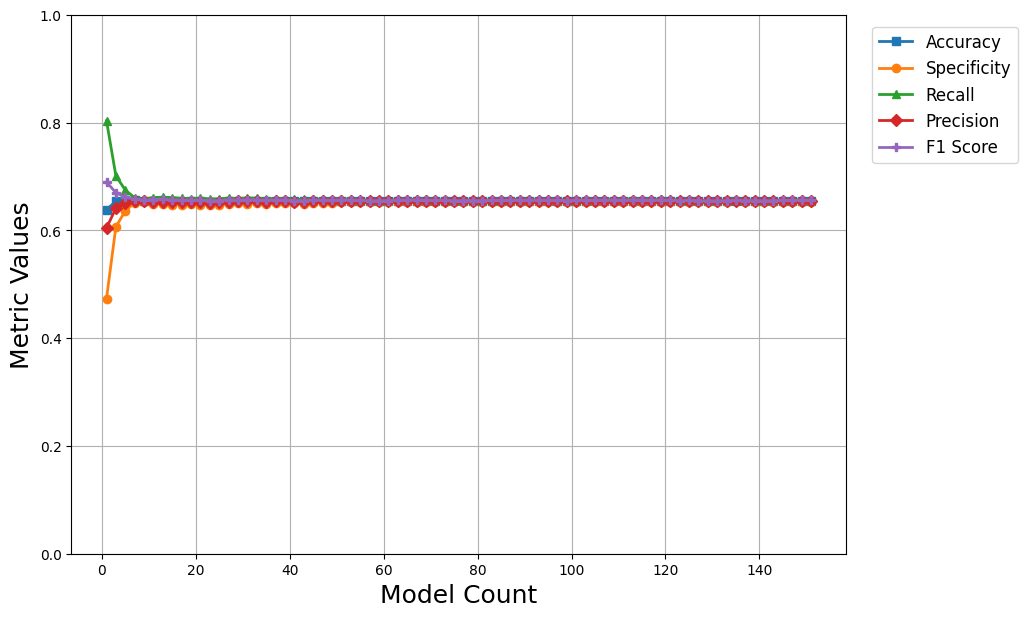

In [27]:
plot_ensemble(model, x_valid, y_valid, model_count, threshold)

### Based on the distribution, 21 models seems to be the best

In [ ]:
use_count = 21

# Evaluating Monte Carlo Dropout Ensemble

In [26]:
def evaluate(a_model, x, y, model_count, threshold):
    '''
    Evaluate a model
    '''
    output_list = collect_output(a_model, x, model_count)
    return evaluate_output(output_list, y, threshold)

In [52]:
evaluate(model, x_train, y_train, use_count, threshold)
evaluate(model, x_valid, y_valid, use_count, threshold)
evaluate(model, x_test, y_test, use_count, threshold)

2304/2304 [==============================] - 23s 10ms/step
Accuracy: 0.6556803385416666
Specificity: 0.6436435622084825
Recall:  0.6677249538695322
Precision:  0.6518755960580693
F1:  0.6597050938337801
480/480 [==============================] - 4s 9ms/step
Accuracy: 0.6520182291666666
Specificity: 0.6453503516540766
Recall:  0.6586826347305389
Precision:  0.6501349094179623
F1:  0.6543808600064661
480/480 [==============================] - 4s 9ms/step
Accuracy: 0.6549479166666666
Specificity: 0.639885595423817
Recall:  0.6700573813249869
Precision:  0.6497218007081437
F1:  0.6597329224447868


[0.6549479166666666,
 0.639885595423817,
 0.6700573813249869,
 0.6497218007081437,
 0.6597329224447868]